# Predicting Delayed Flights using Random Forest Classifier


### Abstract:
In this notebook, I will BTS data on "On Time" performance of flights in 2014 to train a random forest model to predict flight delays, based on the factors of Month, Airline, Origin Airport, Destination Airport, Scheduled Hour of Departure, Calendar Date, Flight Number, and Day of Week. I then evaluate the performance of our model on the available on-time flight data for 2015. Ultimately, I find that our model has an overall accuracy of 73%, with 88% accuracy on true positives, and around 20% on true negative. Finally, I discuss potential enhancements to potentially increase future performance of the model.



## Consolidate 2014 data by appending monthly dataframe and creating new indicator variable "Bad_Indicator"

Our plan is to train on the 2014 data, and test on the 2015 data. The RITA/BTS database only let you download by month, so we will have to concatenate all the months for 2014 into a single dataframe. We are creating a new indicator variable called "Bad_Indicator" which will take on value 1 if a flight is either delayed departure or delayed arrival.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('1-14.csv', dtype={'DEP_TIME_BLK':object})
df2 = pd.read_csv('2-14.csv', dtype={'DEP_TIME_BLK':object})
df3 = pd.read_csv('3-14.csv', dtype={'DEP_TIME_BLK':object})
df4 = pd.read_csv('4-14.csv', dtype={'DEP_TIME_BLK':object})
df5 = pd.read_csv('5-14.csv', dtype={'DEP_TIME_BLK':object})
df6 = pd.read_csv('6-14.csv', dtype={'DEP_TIME_BLK':object})
df7 = pd.read_csv('7-14.csv', dtype={'DEP_TIME_BLK':object})
df8 = pd.read_csv('8-14.csv', dtype={'DEP_TIME_BLK':object})
df9 = pd.read_csv('9-14.csv', dtype={'DEP_TIME_BLK':object})
df10 = pd.read_csv('10-14.csv', dtype={'DEP_TIME_BLK':object})
df11 = pd.read_csv('11-14.csv', dtype={'DEP_TIME_BLK':object})
df12 = pd.read_csv('12-14.csv', dtype={'DEP_TIME_BLK':object})

frames = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12]
df = pd.concat(frames)
#create new column variable which will be 1 if flight is delayed in departure or delayed in arrival
df['Bad_Indicator'] = ((df['DEP_DEL15'] == 1) | (df['ARR_DEL15'] == 1)).astype(int)
df.head()


,YEAR,MONTH,DAY_OF_WEEK,FL_DATE,AIRLINE_ID,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,...,DEP_DELAY_GROUP,DEP_TIME_BLK,CRS_ARR_TIME,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,DIVERTED,Unnamed: 20,Bad_Indicator
0,2014,1,3,2014-01-01,19805,1,12478,31703,12892,32575,...,0,0900-0959,1225,0,0,1200-1259,0,0,NaN,0
1,2014,1,4,2014-01-02,19805,1,12478,31703,12892,32575,...,-1,0900-0959,1225,0,0,1200-1259,0,0,NaN,0
2,2014,1,5,2014-01-03,19805,1,12478,31703,12892,32575,...,NaN,0900-0959,1225,NaN,NaN,1200-1259,1,0,NaN,0
3,2014,1,6,2014-01-04,19805,1,12478,31703,12892,32575,...,4,0900-0959,1225,1,3,1200-1259,0,0,NaN,1
4,2014,1,7,2014-01-05,19805,1,12478,31703,12892,32575,...,7,0900-0959,1225,1,7,1200-1259,0,0,NaN,1


In [40]:
df.shape   #shape of data

(5819811, 22)

In [41]:
df.columns  #view column data

Index([u'YEAR', u'MONTH', u'DAY_OF_WEEK', u'FL_DATE', u'AIRLINE_ID', u'FL_NUM',
       u'ORIGIN_AIRPORT_ID', u'ORIGIN_CITY_MARKET_ID', u'DEST_AIRPORT_ID',
       u'DEST_CITY_MARKET_ID', u'CRS_DEP_TIME', u'DEP_DEL15',
       u'DEP_DELAY_GROUP', u'DEP_TIME_BLK', u'CRS_ARR_TIME', u'ARR_DEL15',
       u'ARR_DELAY_GROUP', u'ARR_TIME_BLK', u'CANCELLED', u'DIVERTED',
       u'Unnamed: 20', u'Bad_Indicator'],
      dtype='object')

#### We have data for 5.8 million flights in 2014, with 22 fields for each flight. Again, Bad_Indicator is an indicator whether or not a flight was delayed, so we will focus on that.

## Now that we have the 2014 dataset, let's play around with it and visualize some relationships. 
#### Let's see delays (the indicator variable "Bad_Indicator", whether a delay was over 15 minutes) as a function of some variables that we intuitively think are important to predicting delays.
#### I hypothesize that we shall see significant variance of delays against month, day of the week, carrier, flight number, day of the year (for example, Thanksgiving flights), and departure time blocks (for example, earlier morning flights might be delayed more).

### January and June are the worst months with almost 30% delay rate. September is the best month with around 20% delay rate

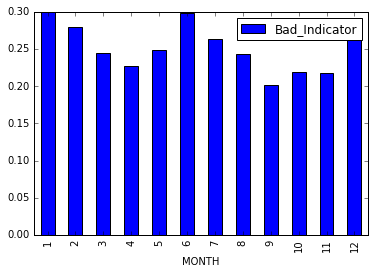

In [5]:
%matplotlib inline
# Compute average number of delayed flights per month
permonth = df[['Bad_Indicator', 'MONTH']].groupby('MONTH').mean()

# plot average delays by month
permonth.plot(kind='bar')

### Southwest and United Airlines are the worst carriers (around 30% delay rate)

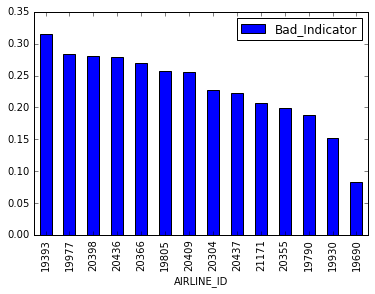

In [6]:
#sort carriers by average delay rate, in descending order
grouped2 = df[['Bad_Indicator', 'AIRLINE_ID']].groupby('AIRLINE_ID').mean()
carrier = grouped2.sort_values(by='Bad_Indicator', ascending=False)

#plot all carriers (only 14)
carrier.plot(kind='bar')

## Some flight numbers are historically very bad, with almost a thousand of delays in a year. 
Of course, this potentially could just be because those flights fly more often than others. Still, the average number of delays in a year is 218, so our evidence shows that there is wide variation of delay based on flight number.

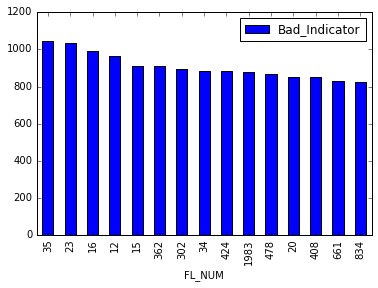

In [28]:
# Compute number of delayed flights by flight number, for flight numbers with over 365 delays
grouped1 = df[['Bad_Indicator', 'FL_NUM']].groupby('FL_NUM').sum()
fl_num = grouped1.sort_values(by='Bad_Indicator', ascending=False)

#plot top 15 worst flight numbers (most delays)
fl_num[:15].plot(kind='bar')

In [182]:
fl_num.describe() #for a given flight number, the average number of delayed flights in a year is 218

,Bad_Indicator
count,6688.000000
mean,218.926585
std,161.285024
min,0.000000
25%,101.000000
50%,181.000000
75%,299.000000
max,1044.000000


### There's a significant difference is flight delays by calendar date. January 15th had 8000 flights delayed. December 8th had 1200. 
Of course, we should take this with a grain of salt since this is all from 2014 so there might be local cause of this variance, so it might not have the best predictive power on 2015. But if we were to incorporate 2013 data in as well (which I will recommend later), this effect will be dampened. 

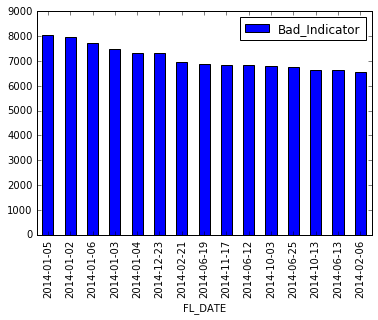

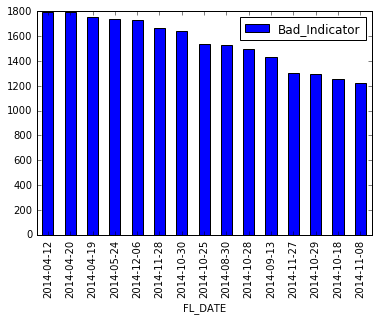

In [8]:
# Compute total number of delayed flights by calendar day
grouped1 = df[['Bad_Indicator', 'FL_DATE']].groupby('FL_DATE').filter(lambda x: len(x)>100)
grouped2 = grouped1.groupby('FL_DATE').sum()
date = grouped2.sort_values(by='Bad_Indicator', ascending=False)

#plot top 15 worst calendar days (most flights delayed)
date[:15].plot(kind='bar')
date[-15:].plot(kind='bar')

In [78]:
date.describe()

,Bad_Indicator
count,365.000000
mean,4011.454795
std,1373.874573
min,1219.000000
25%,3022.000000
50%,3881.000000
75%,4881.000000
max,8046.000000


## Day of the week doesn't seem to be correlated very strongly with number of delays

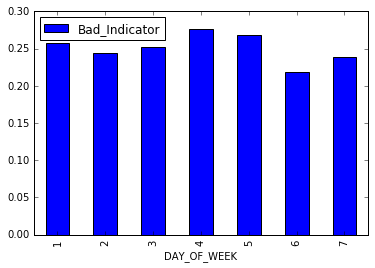

In [9]:
# Compute average number of delayed flights per day of the week
permonth = df[['Bad_Indicator', 'DAY_OF_WEEK']].groupby('DAY_OF_WEEK').mean()

# plot average delays by month
permonth.plot(kind='bar')

## What times of day are most likely to be delayed? Looks like late afternoon: 5pm-9pm. Earlier flights are actually less likely to be delayed.

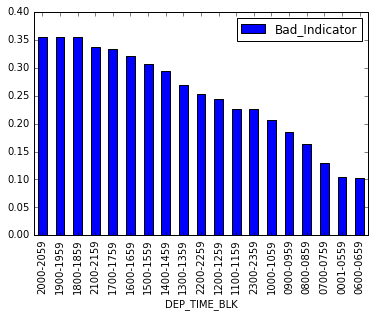

In [10]:
# Compute total number of delayed flights by departure hour
grouped1 = df[['Bad_Indicator', 'DEP_TIME_BLK']].groupby('DEP_TIME_BLK').filter(lambda x: len(x)>100)
grouped2 = grouped1.groupby('DEP_TIME_BLK').mean()
hours = grouped2.sort_values(by='Bad_Indicator', ascending=False)

hours.plot(kind='bar')


## Let's create a new dummy variable "Bad_Hour" to encode whether or not the scheduled departure hour has an average delay rate of over 30%.  
I found through trial and error that using a higher threshold of 30% (as opposed to the mean of around 25%) gives this variable more predictive power at predicting true negatives. 

In [108]:
high_hours = hours[hours['Bad_Indicator']>0.30]['Bad_Indicator'].index
high_hours

Index([u'2000-2059', u'1900-1959', u'1800-1859', u'2100-2159', u'1700-1759',
       u'1600-1659', u'1500-1559'],
      dtype='object', name=u'DEP_TIME_BLK')

In [125]:
dummies = pd.get_dummies(df['DEP_TIME_BLK'])

In [110]:
df['Bad_Hour'] = ((dummies['2000-2059'] == 1) | (dummies['1900-1959'] == 1) | (dummies['1800-1859'] == 1) | (dummies['2100-2159'] == 1) | (dummies['1700-1759'] == 1) | (dummies['1600-1659'] == 1) | (dummies['1500-1559'] == 1 | (dummies['1400-1459'] == 1) | (dummies['1300-1359'] == 1) | (dummies['2200-2259'] == 1) )).astype(int)
df[['DEP_TIME_BLK', 'Bad_Hour']].tail()

,DEP_TIME_BLK,Bad_Hour
477178,1400-1459,0
477179,1800-1859,1
477180,0900-0959,0
477181,1500-1559,1
477182,1200-1259,0


# Similarly, let's create an indicator variable whether or not a flight flies on a calendar day that is historically bad.
6500 and over contains less than 20% of the population, and everything above that will have value 1. Again, having a higher threshold yields more predicitive power of true negatives.

In [111]:
bad_days = date[date['Bad_Indicator']>6500]['Bad_Indicator'].index
bad_days[:10]

Index([u'2014-01-05', u'2014-01-02', u'2014-01-06', u'2014-01-03',
       u'2014-01-04', u'2014-12-23', u'2014-02-21', u'2014-06-19',
       u'2014-11-17', u'2014-06-12'],
      dtype='object', name=u'FL_DATE')

In [112]:
df['Bad_Day'] = (df['FL_DATE'].values[0] in bad_days)#.astype(int)
df['Bad_Day'] = df['Bad_Day'].astype(int)
df[['FL_DATE', 'Bad_Day']].head()

,FL_DATE,Bad_Day
0,2014-01-01,0
1,2014-01-02,0
2,2014-01-03,0
3,2014-01-04,0
4,2014-01-05,0


# Finally, let's do the same thing for flight numbers. Encode all the historically bad flight numbers in an indicator variable.

In [113]:
bad_flights = fl_num[fl_num['Bad_Indicator']>350]['Bad_Indicator'].index #top 25 percentile of bad flights
bad_flights[:10]

Int64Index([35, 23, 16, 12, 15, 362, 302, 34, 424, 1983], dtype='int64', name=u'FL_NUM')

In [114]:
df['Bad_Flight'] = (df['FL_NUM'].values[0] in bad_flights)
df['Bad_Flight'] = df['Bad_Flight'].astype(int)
df[['FL_NUM', 'Bad_Flight']].tail()

,FL_NUM,Bad_Flight
477178,2180,1
477179,3128,1
477180,3317,1
477181,4996,1
477182,178,1


# Now we shall consolidate the 2015 data
Similarly, we need to consolidate the 2015 data set to test our model on (only have data for 2015 up to and including September 2015).

In [115]:
df1b = pd.read_csv('1-15.csv', dtype={'DEP_TIME_BLK':object})
df2b = pd.read_csv('2-15.csv', dtype={'DEP_TIME_BLK':object})
df3b = pd.read_csv('3-15.csv', dtype={'DEP_TIME_BLK':object})
df4b = pd.read_csv('4-15.csv', dtype={'DEP_TIME_BLK':object})
df5b = pd.read_csv('5-15.csv', dtype={'DEP_TIME_BLK':object})
df6b = pd.read_csv('6-15.csv', dtype={'DEP_TIME_BLK':object})
df7b = pd.read_csv('7-15.csv', dtype={'DEP_TIME_BLK':object})
df8b = pd.read_csv('8-15.csv', dtype={'DEP_TIME_BLK':object})
df9b = pd.read_csv('9-15.csv', dtype={'DEP_TIME_BLK':object})

frames = [df1b,df2b,df3b,df4b,df5b,df6b,df7b,df8b,df9b]
dftest = pd.concat(frames)

#create new indicator vars
dftest['Bad_Indicator'] = ((dftest['DEP_DEL15'] == 1) | (dftest['ARR_DEL15'] == 1)).astype(int)
#create bad_hour
dummies = pd.get_dummies(dftest['DEP_TIME_BLK'])
dftest['Bad_Hour'] = ((dummies['2000-2059'] == 1) | (dummies['1900-1959'] == 1) | (dummies['1800-1859'] == 1) | (dummies['2100-2159'] == 1) | (dummies['1700-1759'] == 1) | (dummies['1600-1659'] == 1) | (dummies['1500-1559'] == 1 | (dummies['1400-1459'] == 1) | (dummies['1300-1359'] == 1) | (dummies['2200-2259'] == 1) )).astype(int)
#create bad_day
dftest['Bad_Day'] = (dftest['FL_DATE'].values[0] in bad_days)
dftest['Bad_Day'] = dftest['Bad_Day'].astype(int)
#create bad_flight
dftest['Bad_Flight'] = (dftest['FL_NUM'].values[0] in bad_flights)
dftest['Bad_Flight'] = dftest['Bad_Flight'].astype(int)

dftest.head()

,YEAR,MONTH,DAY_OF_WEEK,FL_DATE,AIRLINE_ID,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,...,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,DIVERTED,Unnamed: 20,Bad_Indicator,Bad_Hour,Bad_Day,Bad_Flight
0,2015,2,7,2015-02-01,19805,1,12478,31703,12892,32575,...,0,-2,1200-1259,0,0,NaN,0,0,0,1
1,2015,2,1,2015-02-02,19805,1,12478,31703,12892,32575,...,NaN,NaN,1200-1259,1,0,NaN,0,0,0,1
2,2015,2,2,2015-02-03,19805,1,12478,31703,12892,32575,...,0,-1,1200-1259,0,0,NaN,0,0,0,1
3,2015,2,3,2015-02-04,19805,1,12478,31703,12892,32575,...,0,-1,1200-1259,0,0,NaN,0,0,0,1
4,2015,2,4,2015-02-05,19805,1,12478,31703,12892,32575,...,0,-1,1200-1259,0,0,NaN,0,0,0,1


# Initialize our training/test dataframes

Note: the final variables I ended up using were Month, Airline, Origin Airport, Destination Airport, Bad Hour, Bad Day, Bad Flight, and Day of Week.

I experimented with combinations of other variables, with the goal of maximizing true negatives. This is super important, because overall accuracy is not the ultimate goal, because I can get 77% accuracy by always predicting 0, and never predicting 1 (delayed) - but that's not a very helpful model, and has 0% accuracy on true negatives. 

I found that including less variables resulted in higher overall accuracy, but lower accuracy on true negatives. This is because the model just ended up making very little predictions for delayed flights.

I found that with this final combination of factors, overall accuracy actually decreased to 73%, but you go from predicting correctly 0 out of 1 million true negatives, to predicting around 200k /1 Million true negatives.

In [119]:
import numpy as np
from sklearn import linear_model as LM
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

#variables we will train on

cols = ['MONTH', 'AIRLINE_ID', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'Bad_Hour', 'Bad_Day', 'Bad_Flight', 'DAY_OF_WEEK']

train_y = df['Bad_Indicator'] > 0
train_x = df[cols]

#test sets
test_y = dftest['Bad_Indicator'] > 0
test_x = dftest[cols]


# Using a Random Forest Classifier
In the appendix, I briefly tried out some other classifiers (SVM, logistic regression), which perform pretty poorly. Random forest is a very effective technique in my opinion, especially with categorical features.

I experimented and found that increasing the number of trees past 10 does not increase overall accuracy nor does it improve true negative accuracy. All it does is make my 5 year old computer incredibly slow.

In [120]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest classifier with 10 trees
rforest = RandomForestClassifier(n_estimators=10, n_jobs=-1)
rforest.fit(train_x, train_y)

# Evaluate on test set
predict = rforest.predict(test_x)

# print results
cm = confusion_matrix(test_y, predict)
print("Confusion matrix")
print(pd.DataFrame(cm))
report_svm = precision_recall_fscore_support(list(test_y), list(predict), average='binary')
print "\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_svm[0], report_svm[1], report_svm[2], accuracy_score(list(test_y), list(predict)))

Confusion matrix
         0       1
0  2988364  387616
1   815338  194394

precision = 0.33, recall = 0.19, F1 = 0.24, accuracy = 0.73



# Summary / Ideas for Next Steps / Improving the model

Our model has 73% overall accuracy: 88% accuracy on true positives, and around 20% on true negative. Of course, the 20% on true negative is not ideal, so here are some ideas moving forward to improve the performance of our model:

### 1. Incorporate weather data
I think the single most significant thing we can do to improve our model is include the variable of weather. Heuristically, weather seems one of the most significant factors in causing flight delays, and it is currently not accounted for in our model. If I had more time, I would add the categorical feature of weather for both the origin and destination airport. 

### 2. More Training Data
Our model might also be improved upon by increasing the size of the training data. Currently we are only using 2014 data, which makes the features of "calendar date" relatively biased to local events (for example, if there was an air traffic control striek on January 18th, 2014). Adding other years' data would help.

### 3. Multiclass Classification
Currently we are looking to predict the value of "Bad_Flight", whether or not a flight is delayed by 15 minutes or longer. In future models, we might like to be more granular than this, and split it up into different variables. For example, we could train our model to predict whether a flight will be 15 mins - 1 hour delayed, 1 hour-2 hour delayed, or 2+ hours delayed. We could also train our model to predict diverted or cancelled flights.

### 4. Multiple Correspondence Analysis
Previously we selected features almost heuristically: we hypothesized which features would be significant, plotted some basic bar graphs, and then performed trial-and-error testing to see which combination resulted in best performance on the test data. Instead, we can use MCA (essentially the categorical analogue of PCA) to see if we can do better. Performing MCA on the whole 2014 data would take too long because it's takes roughly n^3 time, and we have 5.8 million samples in 2014, but we could create a smaller dataset to perform MCA on, and then apply those "features" to the rest of the model.

# Appendix: Mainly the performance of other classification techniques. SVM, logistic regression, and neural nets perform worse than random forest

Interestingly, both SVM and Logistical Classification seem to be much more aggressive at predicting delayed flights, so get more True Negatives, but they are so aggressive that they result in a large decrease in overall accuracy.

## Let's try an SVM Classification Model
Our random forest model seems to be doing pretty well, but let's just see if an SVM model will yield better results on the test data. In general, SVM's don't scale very well so we will use the more scalable LinearSVC. Note that since we have so many more samples than we have features, it will be significantly easier to solve the dual problem than the primal problem.

In [121]:
from sklearn.svm import LinearSVC

svmclass = LinearSVC(C = 1.0, class_weight='balanced', dual=False)
svmclass.fit(train_x,train_y)

# Evaluate on test set
predict = svmclass.predict(test_x)

# print results
cm = confusion_matrix(test_y, predict)
print("Confusion matrix")
print(pd.DataFrame(cm))
report_svm = precision_recall_fscore_support(list(test_y), list(predict), average='binary')
print "\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_svm[0], report_svm[1], report_svm[2], accuracy_score(list(test_y), list(predict)))


Confusion matrix
         0        1
0  2216709  1159271
1   501732   508000

precision = 0.30, recall = 0.50, F1 = 0.38, accuracy = 0.62



## Logistic Classification

In [122]:
#train
classifier = LM.LogisticRegression(penalty='l2', class_weight='balanced')
classifier.fit(train_x, train_y)

#predict
predict = classifier.predict(test_x)

# display evaluation metrics
cm = confusion_matrix(test_y, predict)
print("Confusion matrix")
print(pd.DataFrame(cm))
report_lr = precision_recall_fscore_support(list(test_y), list(predict), average='binary')
print "\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_lr[0], report_lr[1], report_lr[2], accuracy_score(list(test_y), list(predict)))

Confusion matrix
         0        1
0  2213490  1162490
1   500964   508768

precision = 0.30, recall = 0.50, F1 = 0.38, accuracy = 0.62



## Let's try a neural net model as well, just for kicks
We'll use the adam algorithm which performs better for large datasets.

In [ ]:
from sklearn.neural_network.multilayer_perceptron import MLPClassifier

neuralnet = MLPClassifier(algorithm='adam', activation='logistic', alpha=1e-5, hidden_layer_sizes=(3))
#neuralnet = MLPClassifier()
neuralnet.fit(train_x,train_y)
predict = neuralnet.predict(test_x)

# print results
cm = confusion_matrix(test_y, predict)
print("Confusion matrix")
print(pd.DataFrame(cm))
report_svm = precision_recall_fscore_support(list(test_y), list(predict), average='binary')
print "\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_svm[0], report_svm[1], report_svm[2], accuracy_score(list(test_y), list(predict)))